<a href="https://colab.research.google.com/github/Anna-099/Projects/blob/main/Self_motion_illusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Phenomenon: The “train illusion” occurs when sitting in a stationary train and experiencing relative visual motion of an adjacent train outside the window; sometimes we feel like we’re moving even if we’re not (and vice versa). Vestibular signals are used to disambiguate self-motion from motion of an adjacent object.


Question: “How do noisy vestibular estimates of motion lead to illusory percepts of self motion?”

Hypothesis: The strength of the illusion has a linear relationship to the amplitude of vestibular noise. Mathematically, this would write as S = k x N, where S is the illusion strength, N is the noise level, and
 k is a free parameter. As illusion srenght we can use the frequency of occurrence across repetitions. We get the noise as a standard deviation o the vestibular input v(t)--> N = E[v(t)^2]. It is not needed to take the average across time points because we have the generative process, so we can just use σ.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
!pip install pandas --quiet
plt.style.use('dark_background')

In [2]:
### Create vestibular signal generator
def vestibular_signal(sig, mov):
  """
  Computes a vestibular signal that corresponds to the acceleration of the
  train with different amplitudes of noise
  Args:
    sig: scalar SD of noise
    mov: 0 means no self-motion; 1 means self-motion (or scaling or motion signal)
  Returns: vector array of vestibular signal v
  """
  # create white noise series for 10s with 1ms resolution
  x = np.linspace(-7, 14, 1001)
  z = 1/(1 + np.exp(-x))
  noise = norm.rvs(size=1000)
  v = sig*noise + mov*np.diff(z)/0.001
  return v

Text(0, 0.5, 'vestibular signal (a.u.)')

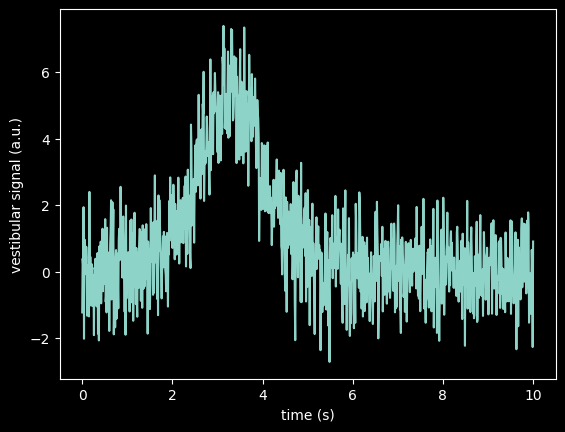

In [3]:
#Unit test
v = vestibular_signal(1,1)
# plot signal
t = np.linspace(0, 10, 1000)
plt.plot(t,v)
plt.xlabel("time (s)")
plt.ylabel("vestibular signal (a.u.)")

In [4]:
###Integrator (Drift Diffusion Model mechanism)
def ddm(v, c):
  """
  Leaky integration of vestibular signal
  Args:
    v: array of vestibular signal
    c: leakage constant
  Outputs: time series of integrated vestibular signal (with leakage)
    = evidence e
  """
  e = np.random.normal(0, 0.1)
  E = []
  for i in range(len(v)):
    e += -c*e + v[i]*0.001
    E.append(e)
  return E

Text(0, 0.5, 'integrated evidence')

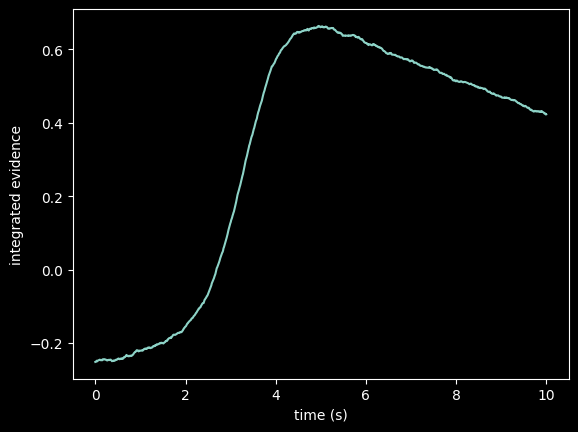

In [6]:
#Unit Test
e = ddm(v,c=0.001)
# plot result
plt.plot(t,e)
plt.xlabel("time (s)")
plt.ylabel("integrated evidence")

In [7]:
###Tresholding - decision mechanism
def threshold(e, thr):
  """
  Thresholding of motion evidence
  Args:
    motion evidence: e (array)
    threshold: thr
  Output: decision d if threshold was reached
  """
  d = any(np.array(e) > thr)*1
  return d

In [8]:
#Unit Test
d = threshold(e, .6)
d

1

In [9]:
###Assembling the model
def run_model(sig,c,thr,mov):
  """
  runs the full model to simulate self-motion decision, e.g. for train illusion
  Args:
    sig: SD of vestibular noise
    c: leakage constant
    thr: decision threshold
    mov: self-motion? ) no selfmotion; 1 self-motion
  Output: decision d (0: no self-motion; 1: self-motion)
  """
  v = vestibular_signal(sig, mov)
  e = ddm(v,c)
  d = threshold(e, thr)
  return d

In [10]:
#Unit Test
d = run_model(200,0.001,0.8,1)
d

1

In [11]:
###Model Evaluation and Testing
import itertools # to automatically generate possible combinations of parameters

# define parameter list
params = {
    'sig': np.linspace(1,21,5)**2,
    'c': np.exp(np.linspace(-10,-1,5)),
    'thr': np.linspace(0,2,5),
    'mov': np.linspace(0,1,2),
}

# run combination of parameters
keys = list(params)
D = []
for i in range(0,100):
  for values in itertools.product(*map(params.get, keys)):
      d = run_model(**dict(zip(keys, values)))
      temp = list(values)
      temp.append(d)
      D.append(temp)

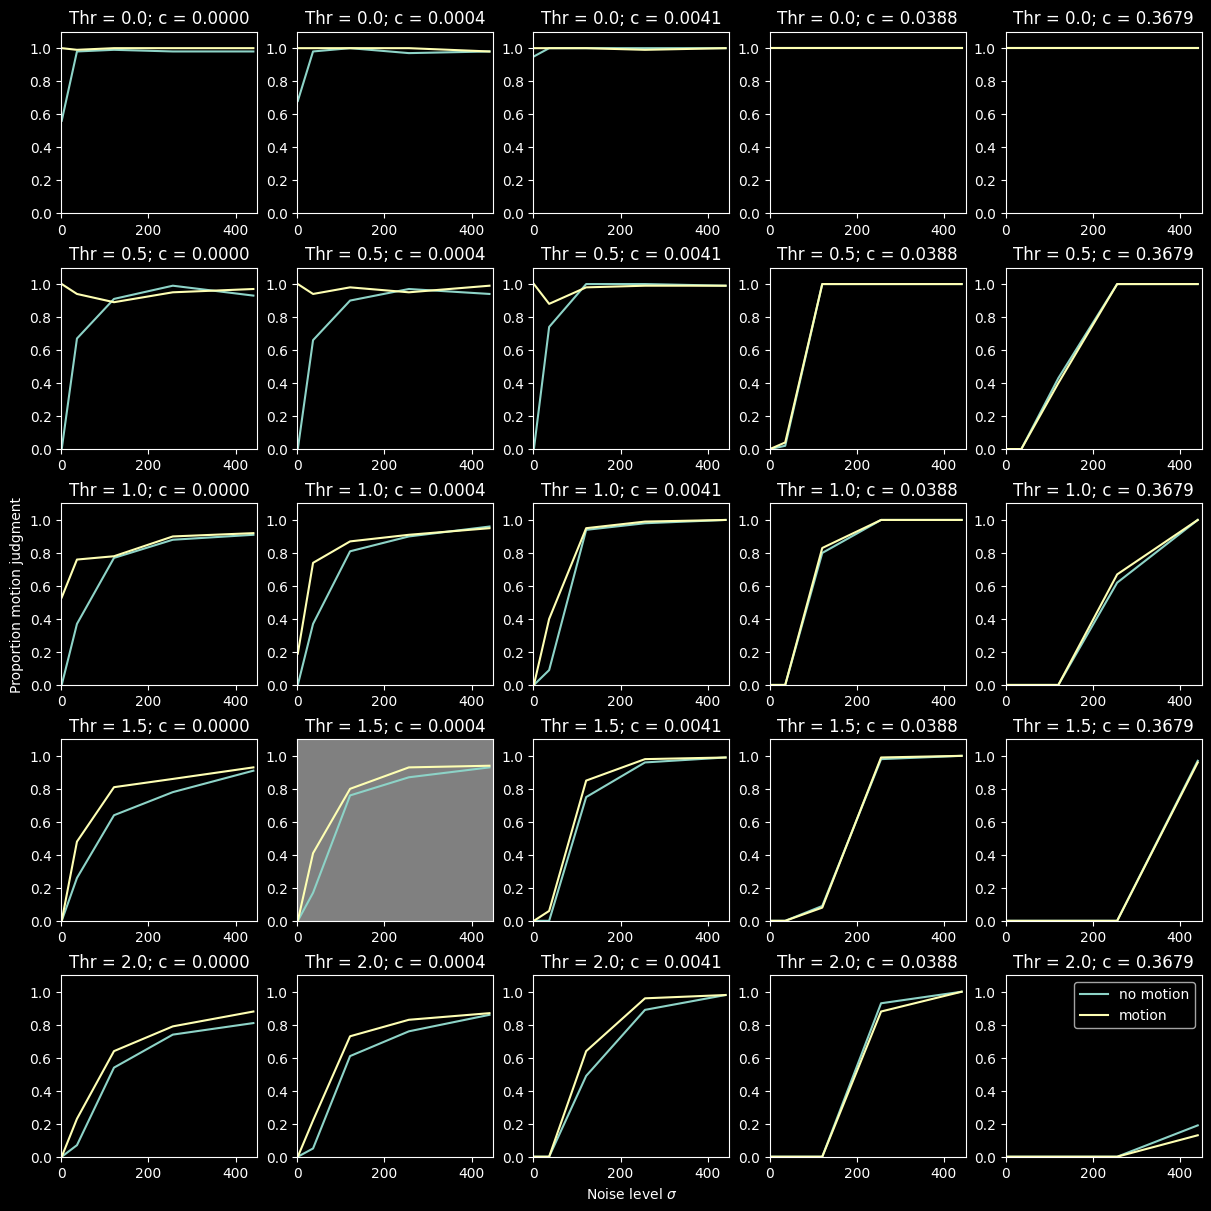

In [12]:
#test hypothesis for different parameter combinations
# want data frames:
import pandas as pd
df = pd.DataFrame(D, columns = ['Sig','c','Thr','Mov','Decisions'])
# multi panel layout:
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(5, 5)
# plot for movement absent/present
Mov_s = np.unique(df['Mov'])
# plot for leakage parameter & threshold values:
c_s   = np.unique(df['c'])
Thr_s   = np.unique(df['Thr'])
# plot for data for both movement condition for each leakage/threshold combination
Sig_s   = np.unique(df['Sig'])
for Thr_n in range(len(Thr_s)):
  for c_n in range(len(c_s)):
    subdf0 = df[(df.Mov == 0) & (df.c == c_s[c_n]) & (df.Thr == Thr_s[Thr_n])].groupby(['Sig'])['Decisions'].mean()
    subdf1 = df[(df.Mov == 1) & (df.c == c_s[c_n]) & (df.Thr == Thr_s[Thr_n])].groupby(['Sig'])['Decisions'].mean()
    im0 = axs[Thr_n, c_n].plot(Sig_s, subdf0, label="no motion")
    im1 = axs[Thr_n, c_n].plot(Sig_s, subdf1, label="motion")
    axs[Thr_n, c_n].set_title("Thr = {}; c = {:.4f}".format(Thr_s[Thr_n], c_s[c_n]))
    axs[Thr_n, c_n].set_ylim(0, 1.1)
    axs[Thr_n, c_n].set_xlim(0, 450)
axs[4,2].set_xlabel("Noise level $\sigma$")
axs[2,0].set_ylabel("Proportion motion judgment")
axs[3,1].set_facecolor('grey')
axs[4,4].legend();

 Higher noise leads indeed to more frequent errors in self-motion perception but this relationship is not linear.

In [13]:
#since it looks like c=0.0004 works well for thr=1.5 and sig=50 we run a few trials on that to analyze those results
#run "best" parameter combination
sig = 50
c = 0.0004
thr = 1.5
d0 = []
d1 = []
for i in range(0,1000):
    d0.append(run_model(sig,c,thr,0))
    d1.append(run_model(sig,c,thr,1))
print('\n Motion detected for no-motion =', sum(d0)/10, '%; and motion =', sum(d1)/10, '%')


 Motion detected for no-motion = 31.7 %; and motion = 61.7 %


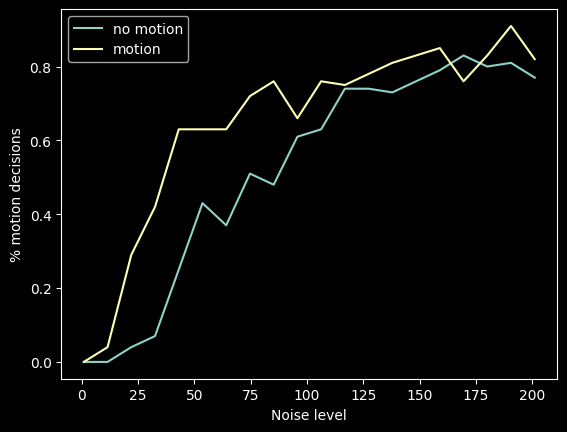

In [14]:
#explicitly evaluate our hypothesis
sig = np.linspace(1,201,20)
c = 0.0004
thr = 1.5
D0 = []
D1 = []
for s in range(len(sig)):
  d0 = []
  d1 = []
  for i in range(0,100):
    d0.append(run_model(sig[s],c,thr,0))
    d1.append(run_model(sig[s],c,thr,1))
  D0.append(sum(d0)/100)
  D1.append(sum(d1)/100)

plt.plot(sig,D0, label="no motion")
plt.plot(sig,D1, label ="motion")
plt.xlabel("Noise level")
plt.ylabel("% motion decisions")
plt.legend();

The hypothesis of linear increase of illusion strength with noise only holds true in a limited range of noise. It is the noise that pushes the integrated signal over the threshold. The less leaky the integration and the lower the threshold, the more motion decisions we get.
Noisy vestibular information can explain the occurrence of the train illusion, and the higher the noise (or the lower the signal-to-noise ratio), the more frequently such illusions will occur.